##  <font style="color:black">**Curso de Analytics de Imagens e Vídeos**</font>

Aula 09 - Classificação de imagens usando CNN

## **Exemplo prático**

### Construção e treinamento de CNN para a classificação das imagens

In [1]:
# Os imports necessários
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [2]:
# baixando base de dados de placas de transito
import urllib.request
import os.path
if not os.path.exists("GTSRB_Final_Training_Images.zip"):
    url = ("https://sid.erda.dk/public/archives/"
    + "daaeac0d7ce1152aea9b61d9f1e19370/"
    + "GTSRB_Final_Training_Images.zip")
    filename = "./GTSRB_Final_Training_Images.zip"
    urllib.request.urlretrieve(url, filename)

In [ ]:
import zipfile

# Caminho do arquivo zip
zip_path = 'GTSRB_Final_Training_Images.zip'

# Pasta onde os arquivos serão extraídos
extract_to = 'GTSRB_Final_Training_Images/'

# Abre e extrai todos os arquivos
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Arquivos extraídos para: {extract_to}")

(30, 29, 3)


In [5]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

data_transforms = {
    # dados de treinamento
    'train': transforms.Compose([
        transforms.Resize((224,224)), # Pré-processamento para formatar as imagens em tamanho (224x224)
        #transforms.RandomHorizontalFlip(), # Rotaciona a imagem de baixo para cima
        transforms.ToTensor(), # Transforma no tipo de dado do pytorch
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Normalização contém a média e o desvio padrão para cada um dos canais RGB
    ]),

    # Podemos fazer cortes diferentes, mas a imagem final tem que ser 224x224
    # dados de validação
    'val': transforms.Compose([
        transforms.Resize(256), # Pré-processamento para formatar as imagens em tamanho (256x256)
        transforms.CenterCrop(224), # Corte na imagem para (224x224)
        transforms.ToTensor(),  # Transforma no tipo de dado do pytorch
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Normalização contém a média e o desvio padrão para cada um dos canais RGB
    ]),
}

# Carrega dataset completo
dataset = datasets.ImageFolder(root='GTSRB_Final_Training_Images/GTSRB/Final_Training/Images', transform=data_transforms['train'])

# Define proporção treino/teste
train_size = int(0.8 * len(dataset))  # 80% treino
test_size = len(dataset) - train_size

# Divide de forma aleatória
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Cria dataloaders
train_loader = DataLoader(train_dataset.dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset.dataset, batch_size=8, shuffle=False)


In [6]:
dataset_sizes = { 'train': train_size, 'val': test_size}

dataloaders = { 'train': train_loader, 'val': test_loader}

In [8]:

# Utiliza GPU ou CPU, verificar no colab (Ambiente de execução -> Alterar o tipo de ambiente de execução)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f'Dataset sizes: {dataset_sizes}')
print(f'class names: {dataset.classes}')
print(f'cuda: {device}')

Dataset sizes: {'train': 31367, 'val': 7842}
class names: ['00000', '00001', '00002', '00003', '00004', '00005', '00006', '00007', '00008', '00009', '00010', '00011', '00012', '00013', '00014', '00015', '00016', '00017', '00018', '00019', '00020', '00021', '00022', '00023', '00024', '00025', '00026', '00027', '00028', '00029', '00030', '00031', '00032', '00033', '00034', '00035', '00036', '00037', '00038', '00039', '00040', '00041', '00042']
cuda: cuda:0


In [9]:
# Funções auxiliares para a classificação das imagens usando CNN

# Função auxiliar para impimir um batch de imagens
def imshow(inp, title=None):
    """Imshow for Tensor."""

    # Reorganizar o dado para o formato adequado do matplotlib
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1) # limita os dados da imagem entre [0,1]
    # plota a imagem
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Apresenta a dimensão de saída da imagem após a convolução (qual o tamanho do feature map?)
def out_conv2d(dim_input, kernel_size, padding=0, dilation=1, stride=1):
    dim_output = ((dim_input + 2 * padding - dilation * (kernel_size-1) - 1)/stride) + 1
    return dim_output

In [10]:
# função de treino
def train_model(model, criterion, optimizer, num_epochs=10):

    # Calcula o tempo do treinamento
    since = time.time()

    # Faz uma cópia do modelo, e a medida que vai melhorando o modelo; atualiza a CNN com os pesos ajustados
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # iterar até a quantidade finita de épocas
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            # calular o erro da época
            running_loss = 0.0

            # calcular a acurácia
            running_corrects = 0

            # Iterate over data.
            #for inputs, labels in dataloaders[phase]:
            
            for inputs, labels in dataloaders[phase]:
                
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zera o parâmetro do gradiente para não obter os gradientes das épocas passadas
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs) # passa os dados de treino para o modelo
                    _, preds = torch.max(outputs, 1) # o resultado da predição
                    loss = criterion(outputs, labels) # o cálculo do erro

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward() # calcula a retropropagação do erro
                        optimizer.step() # atualiza os pesos da CNN com base na retropropagação do erro

                # statistics
                running_loss += loss.item() * inputs.size(0) # calcula o erro das amostras
                running_corrects += torch.sum(preds == labels.data) # calcula a acurácia das amostras

            epoch_loss = running_loss / dataset_sizes[phase] # calcula o erro geral da época atual
            epoch_acc = running_corrects.double() / dataset_sizes[phase] # calcula a acurácia geral da época atual

            # Mostra a fase, o erro, e acurácia da respectiva fase (treinamento ou validação)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Verifica se a acurácia atual é melhor do que a acurácia que está salva.
            # Se for melhor, então atualiza o modelo e os pesos da CNN
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    # verifica o tempo final do treinamento
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Ler o melhor modelo da fase de treinamento
    model.load_state_dict(best_model_wts)
    # retorna o melhor modelo de treino
    return model

In [11]:
class_names = {
    0: "Speed limit (20km/h)",
    1: "Speed limit (30km/h)",
    2: "Speed limit (50km/h)",
    3: "Speed limit (60km/h)",
    4: "Speed limit (70km/h)",
    5: "Speed limit (80km/h)",
    6: "End of speed limit (80km/h)",
    7: "Speed limit (100km/h)",
    8: "Speed limit (120km/h)",
    9: "No passing",
    10: "No passing for vehicles over 3.5 metric tons",
    11: "Right-of-way at the next intersection",
    12: "Priority road",
    13: "Yield",
    14: "Stop",
    15: "No vehicles",
    16: "Vehicles over 3.5 metric tons prohibited",
    17: "No entry",
    18: "General caution",
    19: "Dangerous curve to the left",
    20: "Dangerous curve to the right",
    21: "Double curve",
    22: "Bumpy road",
    23: "Slippery road",
    24: "Road narrows on the right",
    25: "Road work",
    26: "Traffic signals",
    27: "Pedestrians",
    28: "Children crossing",
    29: "Bicycles crossing",
    30: "Beware of ice/snow",
    31: "Wild animals crossing",
    32: "End of all speed and passing limits",
    33: "Turn right ahead",
    34: "Turn left ahead",
    35: "Ahead only",
    36: "Go straight or right",
    37: "Go straight or left",
    38: "Keep right",
    39: "Keep left",
    40: "Roundabout mandatory",
    41: "End of no passing",
    42: "End of no passing by vehicles over 3.5 metric tons"
}


In [29]:
import random
import matplotlib.pyplot as plt
import torch

def visualize_model(model, num_images=6):
    # Salva se o modelo estava em treino ou eval
    was_training = model.training
    model.eval()
    
    fig = plt.figure()
    images_so_far = 0

    # Sorteia índices aleatórios do dataset de validação
    val_dataset = dataloaders['val'].dataset
    indices = random.sample(range(len(val_dataset)), num_images)

    with torch.no_grad():
        for idx in indices:
            # Pega uma imagem e label aleatórios
            img, label = val_dataset[idx]

            # Prepara entrada para o modelo (adiciona dimensão do batch)
            inputs = img.unsqueeze(0).to(device)
            label = torch.tensor(label).to(device)

            # Passa pelo modelo
            outputs = model(inputs)
            _, pred = torch.max(outputs, 1)

            # Plota imagem com predição e rótulo real
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis("off")
            ax.set_title(f"pred: {class_names[pred.item()]}\ntrue: {class_names[label.item()]}")
            imshow(img)

            if images_so_far == num_images:
                break

    # Res


In [13]:
# testando as saidas da camadas conv2d
# Use esta opção para clacular corretamente as dimensões

# Insira a dimensão de entrada (111x111) e o tamanho do filtro (3x3)
# Gera como resultado o tamanho do feature map
out_conv2d(111, 3)

109.0

In [14]:
# Criando uma rede convolucional (topologia da CNN)
class classificador(nn.Module):

  def __init__(self):
    super().__init__()

    # Criação das camadas convolucionais
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3,3)) # saida 222x222 (no pooling cai pela metade -> 111x111) que vai gerar 64 feature maps. Definimos esses parâmetros para a nossa CNN, 64 feature maps e filtro/kernel 3x3
    self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3)) # saida 109x109 (no pooling cai pela metade -> 54x54) que vai gerar 128 feature maps. O kernel eh definido pela própria CNN, mas podemos acessar os valores do kernel criado pela CNN

    # Criação da função relu
    self.activation = nn.ReLU()

    # Criação do pooling
    self.pool = nn.MaxPool2d(kernel_size = (2,2))

    # Criação do flatten para vetorizar a imagem ao final das camadas totalmente conectadas
    self.flatten = nn.Flatten() # 54*54 * 128 channels

    # Camadas lineares da rede neural (os neurônios totalmente conectados)
    self.linear1 = nn.Linear(in_features=128 * 54*54, out_features=128)
    self.linear2 = nn.Linear(128, 64)
    self.output = nn.Linear(64, 43) # gera para as duas classes

    # Dropout para diminuir overfitting (desativa 20% dos neurônios de uma camada oculta)
    self.dropout = nn.Dropout(p = 0.2)

  # Fluxo da passagem da imagem na rede
  def forward(self, X):

    # X = Imagem de entrada 224x224
    # Ao passar a imagem de entrada para a primeira convolução 3x3 a saída eh 222x222
    # Ao passar o pooling na imagem 222x222, então a imagem cai para 111x111
    X = self.pool(self.activation(self.conv1(X)))

    # X = Feature map 111x111
    # Ao passar o feature map para a segunda convolução 3x3 a saída eh 109x109
    # Ao passar o pooling na imagem 109x109, então a imagem cai para 54x54
    X = self.pool(self.activation(self.conv2(X)))

    # 54x54 um único vetor de features
    X = self.flatten(X)

    # desativa 20% dos neurônios da primeira camada oculta
    X = self.dropout(self.activation(self.linear1(X)))

    # desativa 20% dos neurônios da segunda camada oculta
    X = self.dropout(self.activation(self.linear2(X)))

    # passar o dado pela camada de saída
    X = self.output(X)

    # retorna o vetor de ativação do neurônio (valor ponto flutuante, indica a intensidade de ativação do neurônio)
    return X

In [15]:
# Criando objeto da estrutura da rede (topologia da rede)
net = classificador()
print(net)

classificador(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (activation): ReLU()
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=373248, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=43, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [16]:
# Acesso aos pesos da camada especificada pelo nome (primeira camada convolucional)
net.conv1.weight

Parameter containing:
tensor([[[[-0.1731, -0.1760,  0.0648],
          [ 0.0428, -0.1741,  0.1310],
          [-0.0195,  0.1799,  0.1757]],

         [[ 0.1765,  0.0177,  0.1854],
          [-0.1476, -0.0376, -0.1665],
          [-0.0515,  0.0880, -0.1345]],

         [[-0.1025, -0.1386, -0.0427],
          [-0.1784,  0.1267,  0.1207],
          [-0.1169, -0.0809, -0.0485]]],


        [[[-0.1168,  0.0576,  0.0372],
          [-0.0368, -0.1826,  0.0895],
          [-0.0507, -0.0540, -0.0987]],

         [[-0.1897,  0.0145, -0.0607],
          [ 0.1694, -0.1312,  0.0758],
          [ 0.0315,  0.1477, -0.0460]],

         [[ 0.1060, -0.0158, -0.0572],
          [-0.1366,  0.0650,  0.1585],
          [ 0.0898, -0.0467,  0.1292]]],


        [[[-0.0445,  0.1259,  0.1707],
          [-0.0543,  0.1422,  0.0847],
          [ 0.1669,  0.1189,  0.0271]],

         [[ 0.1616,  0.0059, -0.1201],
          [-0.1552,  0.1587,  0.1006],
          [ 0.0251, -0.0358, -0.0536]],

         [[-0.1770,  0

In [17]:
# Acesso ao bis da camada especificada pelo nome (primeira camada convolucional)
net.conv1.bias

Parameter containing:
tensor([ 0.1319, -0.1417, -0.1505, -0.1708,  0.1767,  0.1213,  0.1137, -0.1246,
        -0.1529, -0.1021, -0.1065, -0.1233,  0.0102,  0.1129, -0.0461,  0.1667,
         0.1494,  0.1206, -0.0155, -0.0359, -0.1792,  0.0359,  0.1251, -0.0721,
         0.0448,  0.1779, -0.0540,  0.0353,  0.0358, -0.1787, -0.1375,  0.1777,
        -0.1148, -0.0563, -0.0005,  0.0096,  0.1492,  0.0969,  0.0458,  0.0771,
        -0.0922, -0.0203, -0.0442,  0.0040, -0.1195, -0.0121,  0.1863, -0.1806,
         0.0531,  0.0146, -0.1210,  0.1756,  0.1918, -0.0275, -0.1920, -0.1802,
         0.1700,  0.0999, -0.0590, -0.0002,  0.1286,  0.0677, -0.0626, -0.0077],
       requires_grad=True)

In [18]:
# Definindo os parâmetros importantes do treinamento

# Função de custo e função de otimização dos parâmetros
criterion = nn.CrossEntropyLoss() # define o critério do erro (função de perda eh entropia)
optimizer = optim.SGD(net.parameters(), lr=0.01) # define a taxa de aprendizado e o otimizador SGD (Stochastic gradient descent)

In [19]:
# Colocar a rede na GPU
net.to(device)

classificador(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (activation): ReLU()
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=373248, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=43, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [20]:
print(net)

classificador(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (activation): ReLU()
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=373248, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=43, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [21]:
# treinar o modelo. Apresentar os dados de treino para treinar o modelo
trained_model = train_model(net, criterion, optimizer, num_epochs=15)

Epoch 0/14
----------
train Loss: 2.5654 Acc: 0.4757
val Loss: 5.6531 Acc: 3.1727

Epoch 1/14
----------
train Loss: 1.3998 Acc: 0.7902
val Loss: 3.7479 Acc: 3.7108

Epoch 2/14
----------
train Loss: 0.9830 Acc: 0.9319
val Loss: 2.8530 Acc: 4.0654

Epoch 3/14
----------
train Loss: 0.7287 Acc: 1.0139
val Loss: 1.3548 Acc: 4.6419

Epoch 4/14
----------
train Loss: 0.5626 Acc: 1.0713
val Loss: 1.0062 Acc: 4.7610

Epoch 5/14
----------
train Loss: 0.3927 Acc: 1.1272
val Loss: 0.4379 Acc: 4.8828

Epoch 6/14
----------
train Loss: 0.3118 Acc: 1.1534
val Loss: 0.3010 Acc: 4.9176

Epoch 7/14
----------
train Loss: 0.2356 Acc: 1.1761
val Loss: 0.4286 Acc: 4.8602

Epoch 8/14
----------
train Loss: 0.1934 Acc: 1.1906
val Loss: 0.3541 Acc: 4.8994

Epoch 9/14
----------
train Loss: 0.1627 Acc: 1.1995
val Loss: 0.1157 Acc: 4.9746

Epoch 10/14
----------
train Loss: 0.1459 Acc: 1.2053
val Loss: 0.1302 Acc: 4.9640

Epoch 11/14
----------
train Loss: 0.1231 Acc: 1.2131
val Loss: 0.1532 Acc: 4.9629

Ep

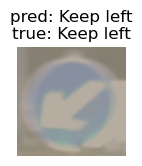

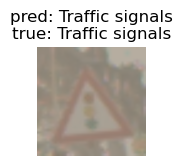

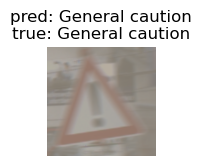

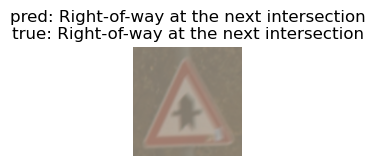

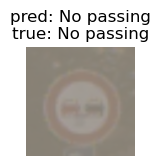

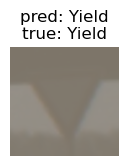

In [30]:
# Visualizar a predição de alguns dados de teste (6 imagens)
visualize_model(trained_model)

### Redes Neurais convolucionais pré treinadas e Transfer Learning

Existem modelos pré treinados disponíveis no módulo models do pytorch.

Estas redes foram treinadas e validadas em competições e são capzaes de classificar várias coisas: 1000 classes.

Podemos usar estas redes como base para os nossos problemas e retreiná-las com os nossos dados.



In [ ]:
# Carregando o modelo pré-treinado VGG16 (CNN) do pytorch
model_ft = models.vgg16(pretrained=True)

In [ ]:
# Mostra a topologia/estrutura da CNN VGG16
print(model_ft)

In [ ]:
# Acessando a quantidade de neurônios da última camada oculta (4096)
num_ftrs = model_ft.classifier[6].in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
# Foi removido a camada de 1000 classes e substituído por 2 classes de saída
# E criado uma nova camada (4096, 2) para substituir a camada oculta existente
# Assim, usamos o modelo pré treinado da VGG16 para o nosso problema em questão
model_ft.classifier[6] = nn.Linear(num_ftrs, 2)

# Apresenta a rede para GPU
model_ft = model_ft.to(device)

# Define os critérios
criterion = nn.CrossEntropyLoss()

# Define o otimizador e a taxa de aprendizado
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001)

In [ ]:
# imprime a estrutura/topologia do modelo
print(model_ft)

In [ ]:
# treinar a última camada da rede CNN, e apresentar o que a rede extraiu de features do VGG16
trained_model = train_model(model_ft, criterion, optimizer_ft, num_epochs=15)

In [ ]:
# Visualiza a predição de alguns dados de teste (6 imagens)
visualize_model(trained_model)